<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/qo20b88v1hbjztubt06609ovs85q8fau.png" width="400px" align="center"></a>

<br><br>

<h1 align="center"><font size="5">Project: Character Modeling</font></h1>

<font size="3"><strong>In this notebook you will use TensorFlow to create a Recurrent Neural Network, to predict the next character in a string. You need to train your network using a CPU and using a GPU and benchmark the result to see which which device You have to write your code in empty cells in this notebook to make it complete, and then submit the notebook for peer-review.</strong></font>

<h2>Table of Contents</h2>
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#lstm">Long Short-Term Memory Model (LSTM) Architectures</a></li>
    <li><a href="#cpu_vs_gpu">Train your model using CPU and GPU</a>
        <ol>
            <li><a href="#question_1">Question 1: Complete the code to run it on CPU</a></li>
            <li><a href="#question_2">Question 2: Complete the code to run it on GPU</a></li>
            <li><a href="#question_3">Question 3: Compare the results</a></li>
        </ol>    
    </li>
</ul>
<p></p>
</div>
<br>
<hr>

<a id="intro"></a>
<h2>Introduction</h2>

<p>This code is supposed to implement a Recurrent Neural Network with LSTM units for training/sampling from character-level language models. In other words, the model takes a text file as input and trains the RNN network that learns to predict the next character in a sequence.</p>  
The RNN can then be used to generate text character by character that will look like the original training data. 

<p>This code is based on this <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">blog</a>, and the code is an step-by-step implementation of the <a href="https://github.com/crazydonkey200/tensorflow-char-rnn">character-level implimentation</a>.</p>

<p>I recommend you to complete the "<a href="https://www.edx.org/course/deep-learning-with-tensorflow">Deep Learning with TensorFlow</a>" course for this project.</p>

First, lets import the required libraries:

In [1]:
import tensorflow as tf
import time
import codecs
import os
import collections
from six.moves import cPickle
import numpy as np
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Libraries
<ul>
    <li><b>os</b>: is an module that allows us to interact with the operating systerm, in particular we will use it to set the path in which we will be storing our input file, tensor file and vocab file</li>
    <li><b>time</b>: is a library that allows us to access the clock time of our machine, we will use it to measure the performance of training our model with a CPU, versus training our model with a GPU</li>
    <li><b>cPickle</b>: is a library for serializing and deserializing python objects, we will use the <b>dump()</b> method in cPickle to serialize our objects when saving them, and <b>load()</b> method in cPickle to deserialize our objects when loading.</li>
    <li><b>codec</b>: is a library that deals with character encoding, we will use the <b>open()</b> method as it is recommended when opening encoded text files.</li>
    <li><b>collections</b>: is a library that implements high performance container types, we will use the <b>Counter</b> object to get a collection of frequencies for our characters</li>
</ul>

<h3>Downloading the input data</h3>
Lets download the input file, and take a look at some parts of it:

In [2]:
!wget -nv -O input.txt https://ibm.box.com/shared/static/a3f9e9mbpup09toq35ut7ke3l3lf03hg.txt 
with open('input.txt', 'r') as f:
    read_data = f.read()
    print("-------------Sample text---------------")
    print (read_data[0:500])
    print("---------------------------------------")
f.closed

2018-12-19 10:41:40 URL:https://public.boxcloud.com/d/1/b1!p-P4om_5-SQbKQRsy2SENQeA7Pgosfzh226IxfFQZJ4-AUW8C0du-PK7ZecpqQxI7rFHkzXu05Yddltx6MzKwm1tF2DuafAp42iqq92JnrP7JLrpbMdKOqElTDDEfvqA1r60Kr8wH6xhiWjWd3uIvenLy2RA5vKSEujfARUu94O-p1IHV6SyJAAp1zrhaZQ_zNuixsiEF5XOe49nuOwC80aqZH-uJu2J2LXhIIL3saS2yO74czX11eXOM3kIhZOmdECf96RPnDOlZsvabX6G_XyqIh0sspzj7cwHZAzTru3FKDtvQwLsdvKiKek3_58AvBuc3hWSDM8xYJFYpmWdwc7lQ93onnKz__dkhYqm4H6Kc0M85Owfq9ACVrxW0m4cLpYz-havYmZlqiRADk1p_AZ4K69yoM0ysVapY2eiG97u1mteBeQGRN_NRUoGuLF-ri5BMfgNSVozPxlFFtMoyNfvlgaI3c9NgLnDeYqJn6w5i4PhIHwfocE61Bn4MKi7YDqa4rgxN9wXmwDgVM8HqlNAFdZZWjUM-y7l9J7m3JfuKNzSoGSkNU7TJ-UkEUsqyr0ltDEU5sigOzsryCWhVToEznij32rJG4nHdLcvmST8yBPAOnsk1ao1OOQidh9IMKedqtR7UWwwdJQwJB_xV-2bedFpXp2q68Ur5Hzj9z-bs8FVt9VSlJ8gFD4FRexpExcnlwfo_6cXtUY_g2jWOgpBwu3zFhSdMwNSwSGIXrLCfQCMrB89LHdJ3_Xff7jhvd2mMzr8AIy0VRyUieDHLmsdrLfwJJnxzFPOU6egXZ_0E42g7GC8Pz12bPCiKYBGf8ZZf-WzSHLGGHMNh42xAlvzo82h5CflK-rZP1EKaxf1JZI1NaiVzG9vteXj6VPR30jKZCdSWtM1b77OSvURWMycwK8Xt9avm_CNQUV0woX1s

True

<h3>Data loader</h3>
You need to read the input file and convert each character to numerical values. The following cell is a class that helps to read data from input file.

In [3]:
class TextLoader():
    def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.encoding = encoding

        input_file = os.path.join(data_dir, "input.txt")
        vocab_file = os.path.join(data_dir, "vocab.pkl")
        tensor_file = os.path.join(data_dir, "data.npy")

        if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
            print("reading text file")
            self.preprocess(input_file, vocab_file, tensor_file)
        else:
            print("loading preprocessed files")
            self.load_preprocessed(vocab_file, tensor_file)
        self.create_batches()
        self.reset_batch_pointer()

    def preprocess(self, input_file, vocab_file, tensor_file):
        with codecs.open(input_file, "r", encoding=self.encoding) as f:
            data = f.read()
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        with open(vocab_file, 'wb') as f:
            cPickle.dump(self.chars, f)
        self.tensor = np.array(list(map(self.vocab.get, data)))
        np.save(tensor_file, self.tensor)

    def load_preprocessed(self, vocab_file, tensor_file):
        with open(vocab_file, 'rb') as f:
            self.chars = cPickle.load(f)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

    def create_batches(self):
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        # When the data (tensor) is too small, let's give them a better error message
        if self.num_batches==0:
            assert False, "Not enough data. Make seq_length and batch_size small."

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
        xdata = self.tensor
        ydata = np.copy(self.tensor)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)


    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        return x, y

    def reset_batch_pointer(self):
        self.pointer = 0

<h3>Parameters</h3>

<p>We have to convert the characters in the string to numbers. Also we need to represent each sequence of characters as a vector in each batch.</p>
So, let's set some parameters that we need those now for reading the dataset, and later to build the model.

In [4]:
seq_length = 50 # RNN sequence length
batch_size = 128  # minibatch size, i.e. size of data in each epoch
num_epochs = 20 # you should change it to 50 if you want to see a relatively good results
learning_rate = 0.002
decay_rate = 0.97
rnn_size = 128 # size of RNN hidden state (output dimension)
num_layers = 2 #number of layers in the RNN

<p>Now, we can read the data at batches using the <b>TextLoader</b> class. It will convert the characters to numbers, and represent each sequence as a vector in batches:</p>

In [5]:
data_loader = TextLoader('', batch_size, seq_length)
vocab_size = data_loader.vocab_size
print ("vocabulary size:" ,data_loader.vocab_size)
print ("Characters:" ,data_loader.chars)
print ("vocab number of 'F':",data_loader.vocab['F'])
print ("Character sequences (first batch):", data_loader.x_batches[0])

reading text file
vocabulary size: 65
Characters: (' ', 'e', 't', 'o', 'a', 'h', 's', 'r', 'n', 'i', '\n', 'l', 'd', 'u', 'm', 'y', ',', 'w', 'f', 'c', 'g', 'I', 'b', 'p', ':', '.', 'A', 'v', 'k', 'T', "'", 'E', 'O', 'N', 'R', 'S', 'L', 'C', ';', 'W', 'U', 'H', 'M', 'B', '?', 'G', '!', 'D', '-', 'F', 'Y', 'P', 'K', 'V', 'j', 'q', 'x', 'z', 'J', 'Q', 'Z', 'X', '3', '&', '$')
vocab number of 'F': 49
Character sequences (first batch): [[49  9  7 ...  1  4  7]
 [39  5  3 ...  0 20  9]
 [ 0  5  9 ... 19  4 13]
 ...
 [ 3 18 18 ...  1  0 23]
 [ 7  1 23 ... 18  3  7]
 [47 26 24 ...  0  8  3]]


<b>Notice:</b> In the following cells, we just go through the process of defining each element of the LSTM, and explore the inputs, outputs of each layer. Then, we put all together and run the network.

<h3>1- Input and Output</h3>
In the next cell we just take a look at a sample batch to underestand the data better. Each batch includes the input, <b>x</b>, and the character that we want to predict, <b>y</b>:

In [6]:
x, y = data_loader.next_batch()
x

array([[49,  9,  7, ...,  1,  4,  7],
       [39,  5,  3, ...,  0, 20,  9],
       [ 0,  5,  9, ..., 19,  4, 13],
       ...,
       [ 3, 18, 18, ...,  1,  0, 23],
       [ 7,  1, 23, ..., 18,  3,  7],
       [47, 26, 24, ...,  0,  8,  3]])

In [7]:
x.shape  #batch_size =128, seq_length=50

(128, 50)

Here, __y__ is the next character for each character in __x__:

In [8]:
y

array([[ 9,  7,  6, ...,  4,  7,  0],
       [ 5,  3,  0, ..., 20,  9, 27],
       [ 5,  9, 14, ...,  4, 13, 20],
       ...,
       [18, 18,  9, ...,  0, 23, 11],
       [ 1, 23,  3, ...,  3,  7,  0],
       [26, 24, 10, ...,  8,  3,  2]])

<a id="lstm"></a>
<h3>2- What is Long Short-Term Memory Model (LSTM)?</h3>

<p>Recurrent Neural Networks are Deep Learning models with simple structures and a feedback mechanism built-in, or in different words, the output of a layer is added to the next input and fed back to the same layer.</p>

<p>The Recurrent Neural Network is a specialized type of Neural Network that solves the issue of <b>maintaining context for Sequential data</b> -- such as Weather data, Stocks, Genes, etc. At each iterative step, the processing unit takes in an input and the current state of the network, and produces an output and a new state that is <b>re-fed into the network</b>.</p>

<p>However, <b>this model has some problems</b>. It's very computationally expensive to maintain the state for a large amount of units, even more so over a long amount of time. Additionally, Recurrent Networks are very sensitive to changes in their parameters. To solve these problems, we use a specific type of RNN, is called Long Short-Term Memory (LSTM).</p>


Each LSTM cell has 5 parts:
<ol>
    <li>Input</li>
    <li>prv_state</li>
    <li>prv_output</li>
    <li>new_state</li>
    <li>new_output</li>
</ol>

<ul>
    <li>Each LSTM cell has an input layer, which its size is 128 units in our case. The input vector's dimension also is 128, which is the dimensionality of embedding vector, so called, dimension size of Word2Vec embedding, for each character.</li>
    <li>Each LSTM cell has a hidden layer, where there are some hidden units. The argument n_hidden=128 of BasicLSTMCell is the number of hidden units of the LSTM (inside A). It keeps the size of the output and state vector. It is also known as, rnn_size, num_units, num_hidden_units, and LSTM size, in literature.</li>
    <li>An LSTM keeps two pieces of information as it propagates through time:</li> 
    <ul>
         <li><b>hidden state</b> vector: Each LSTM cell accept a vector, called <b>hidden state</b> vector, of size n_hidden=128, and its value is returned to the LSTM cell in the next step. The <b>hidden state</b> vector; which is the memory of the LSTM, accumulates using its (forget, input, and output) gates through time. "num_units" is equivalant to "size of RNN hidden state". Number of hidden units is the dimensianality of the output (= dimesianality of the state) of the LSTM cell.</li>
        <li><b>previous time-step output</b>: For each LSTM cell that we initialize, we need to supply a value (128 in this case) for the hidden dimension, or as some people like to call it, the number of units in the LSTM cell.</li> 
    </ul>
</ul>
<br>

<h4>Stacked LSTM</h4>
<p>What about if we want to have a RNN with stacked LSTM? For example, a 2-layer LSTM. In this case, the output of the first layer will become the input of the second.</p>

num_layers = 2 
<ul>
    <li>number of layers in the RNN, is defined by <code>num_layers</code> parameter.</li>
    <li>An input of MultiRNNCell is <b>cells</b> which is list of RNNCells that will be composed in this order.</li>
</ul>
<br>

<h3>3- Defining stacked RNN Cell</h3>

<b>BasicRNNCell</b> is the most basic RNN cell.

In [9]:
# to define a LSTM cell
cell = tf.contrib.rnn.BasicRNNCell(rnn_size)
# a two layer cell
stacked_cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
# hidden state size
stacked_cell.output_size

128

<b>state</b> variable keeps output and new_state of the LSTM, so it is double in size:

In [10]:
stacked_cell.state_size

(128, 128)

Lets define the input data:

In [11]:
input_data = tf.placeholder(tf.int32, [batch_size, seq_length])# a 128x50
input_data

<tf.Tensor 'Placeholder:0' shape=(128, 50) dtype=int32>

and target data, what we want to predict:

In [12]:
targets = tf.placeholder(tf.int32, [batch_size, seq_length]) # a 128x50
targets

<tf.Tensor 'Placeholder_1:0' shape=(128, 50) dtype=int32>

The memory state of the network is initialized with a vector of zeros and gets updated after reading each character.

<b>BasicRNNCell.zero_state(batch_size, dtype)</b> Return zero-filled state tensor(s). In this function, batch_size
representing the batch size.

In [13]:
initial_state = stacked_cell.zero_state(batch_size, tf.float32) 
initial_state

(<tf.Tensor 'MultiRNNCellZeroState/BasicRNNCellZeroState/zeros:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'MultiRNNCellZeroState/BasicRNNCellZeroState_1/zeros:0' shape=(128, 128) dtype=float32>)

Lets check the value of the input_data again:

In [14]:
session = tf.Session(config=config)
feed_dict={input_data:x, targets:y}
session.run(input_data, feed_dict)

array([[49,  9,  7, ...,  1,  4,  7],
       [39,  5,  3, ...,  0, 20,  9],
       [ 0,  5,  9, ..., 19,  4, 13],
       ...,
       [ 3, 18, 18, ...,  1,  0, 23],
       [ 7,  1, 23, ..., 18,  3,  7],
       [47, 26, 24, ...,  0,  8,  3]], dtype=int32)

<h3>4- Embedding</h3>
<p>In this section, we build a 128-dim vector for each character. As we have 60 batches, and 50 character in each sequence, it will generate a [60,50,128] matrix.</p>

<p><b>Notice:</b> The function <code>tf.get_variable()</code> is used to share a variable and to initialize it in one place. <code>tf.get_variable()</code> is used to get or create a variable instead of a direct call to <code>tf.Variable</code>.</p>

In [15]:
with tf.variable_scope('rnnlm', reuse=False):
    softmax_w = tf.get_variable("softmax_w", [rnn_size, vocab_size]) #128x65
    softmax_b = tf.get_variable("softmax_b", [vocab_size]) # 1x65)
    #with tf.device("/cpu:0"):
        
    # embedding variable is initialized randomely
    embedding = tf.get_variable("embedding", [vocab_size, rnn_size])  #65x128

    # embedding_lookup goes to each row of input_data, and for each character in the row, finds the correspond vector in embedding
    # it creates a 60*50*[1*128] matrix
    # so, the first elemnt of em, is a matrix of 50x128, which each row of it is vector representing that character
    em = tf.nn.embedding_lookup(embedding, input_data) # em is 60x50x[1*128]
    # split: Splits a tensor into sub tensors.
    # syntax:  tf.split(split_dim, num_split, value, name='split')
    # it will split the 60x50x[1x128] matrix into 50 matrix of 60x[1*128]
    inputs = tf.split(em, seq_length, 1)
    # It will convert the list to 50 matrix of [60x128]
    inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

Lets take a look at the <b>embedding</b>, <b>em</b>, and <b>inputs</b> variables:

Embedding variable is initialized with random values:

In [16]:
session.run(tf.global_variables_initializer())
#print embedding.shape
session.run(embedding)

array([[-0.05787376,  0.09777106, -0.01986487, ..., -0.08642434,
        -0.14319251, -0.05569399],
       [ 0.01136455, -0.0869826 , -0.05713146, ..., -0.06509905,
         0.08871754,  0.06806371],
       [-0.15317357,  0.12509303,  0.0385263 , ...,  0.00414486,
        -0.05946085, -0.04184119],
       ...,
       [ 0.17017014, -0.07814808, -0.16283244, ..., -0.04653069,
        -0.14331262, -0.06203476],
       [-0.12362595,  0.00628847, -0.1518068 , ..., -0.16526507,
         0.1106009 , -0.06050031],
       [-0.13625726, -0.14515017,  0.08654864, ..., -0.13329075,
         0.02063555,  0.01519786]], dtype=float32)

The first elemnt of em, is a matrix of 50x128, which each row of it is vector representing that character

In [17]:
em = tf.nn.embedding_lookup(embedding, input_data)
emp = session.run(em,feed_dict={input_data:x})
print (emp.shape)
emp[0]

(128, 50, 128)


array([[ 0.05026506,  0.0483537 , -0.16645512, ..., -0.11746354,
        -0.05906019,  0.15754391],
       [ 0.06259702,  0.06746395,  0.15970178, ..., -0.00520723,
        -0.09716283,  0.0787944 ],
       [ 0.01854464,  0.10351239,  0.12049185, ..., -0.17501798,
        -0.1106068 ,  0.04584217],
       ...,
       [ 0.01136455, -0.0869826 , -0.05713146, ..., -0.06509905,
         0.08871754,  0.06806371],
       [ 0.07412462,  0.08883251, -0.11985459, ..., -0.00286956,
         0.1421149 , -0.07374641],
       [ 0.01854464,  0.10351239,  0.12049185, ..., -0.17501798,
        -0.1106068 ,  0.04584217]], dtype=float32)

<p>Let's consider each sequence as a sentence of length 50 characters, then, the first item in <b>inputs</b> is a [60x128] vector which represents the first characters of 60 sentences.</p>

In [18]:
inputs = tf.split(em, seq_length, 1)
inputs = [tf.squeeze(input_, [1]) for input_ in inputs]
inputs[0:5]

[<tf.Tensor 'Squeeze:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_1:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_2:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_3:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_4:0' shape=(128, 128) dtype=float32>]

<h3>5- Feeding a batch of 50 sequence to a RNN:</h3>

The feeding process for inputs is as following:
<ul>
    <li>Step 1: first character of each of the 50 sentences (in a batch) is entered in parallel.</li>  
    <li>Step 2: second character of each of the 50 sentences is input in parallel.</li> 
    <li>Step n: nth character of each of the 50 sentences is input in parallel.</li>  
</ul>
<p>The parallelism is only for efficiency. Each character in a batch is handled in parallel, but the network sees one character of a sequence at a time and does the computations accordingly. All the computations involving the characters of all sequences in a batch at a given time step are done in parallel.</p>

In [19]:
session.run(inputs[0],feed_dict={input_data:x})

array([[ 0.05026506,  0.0483537 , -0.16645512, ..., -0.11746354,
        -0.05906019,  0.15754391],
       [ 0.04501016, -0.10420722,  0.15641366, ..., -0.07127621,
         0.06273495, -0.16892079],
       [-0.05787376,  0.09777106, -0.01986487, ..., -0.08642434,
        -0.14319251, -0.05569399],
       ...,
       [-0.16690256,  0.06780693,  0.0681033 , ...,  0.03731272,
         0.03360038, -0.03427184],
       [ 0.01854464,  0.10351239,  0.12049185, ..., -0.17501798,
        -0.1106068 ,  0.04584217],
       [-0.03007002,  0.05818199,  0.15866797, ...,  0.01219386,
        -0.12532997,  0.02403533]], dtype=float32)

Feeding the RNN with one batch, we can check the new output and new state of network:

In [20]:
#outputs is 50x[60*128]
outputs, new_state = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, initial_state, stacked_cell, loop_function=None, scope='rnnlm')
new_state

(<tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_98:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_99:0' shape=(128, 128) dtype=float32>)

In [21]:
outputs[0:5]

[<tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_1:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_3:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_5:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_7:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_9:0' shape=(128, 128) dtype=float32>]

Let's check the output of network after feeding it with first batch:

In [22]:
first_output = outputs[0]
session.run(tf.global_variables_initializer())
session.run(first_output,feed_dict={input_data:x})

array([[-0.04174314, -0.00508663,  0.02291773, ..., -0.0890485 ,
        -0.02434445, -0.03405511],
       [ 0.02795288,  0.06059858,  0.04302805, ...,  0.11398719,
         0.04985251,  0.02480424],
       [ 0.08483113, -0.02108344,  0.02050352, ...,  0.02295638,
         0.03607686,  0.00397849],
       ...,
       [ 0.07296259, -0.01119115, -0.04389011, ...,  0.00993097,
         0.01978138, -0.05708756],
       [-0.08295654, -0.06755599, -0.0021375 , ..., -0.03761024,
         0.00770046,  0.01273827],
       [-0.02646136,  0.01961071,  0.00337534, ..., -0.08352562,
         0.11154692, -0.03129376]], dtype=float32)

<p>As it was explained, <b>outputs</b> variable is a 50x[60x128] tensor. We need to reshape it back to [60x50x128] to be able to calculate the probablity of the next character using the softmax. The <b>softmax_w</b> shape is [rnn_size, vocab_size], which is [128x65] in our case. Therefore, we have a fully connected layer on top of LSTM cells, which help us to decode the next charachter. We can use the <b>softmax(output * softmax_w + softmax_b)</b> for this purpose. The shape of the matrixis would be:</p>

softmax([60x50x128]x[128x65]+[1x65]) = [60x50x65]

We can do it step-by-step:

In [23]:
output = tf.reshape(tf.concat( outputs,1), [-1, rnn_size])
output

<tf.Tensor 'Reshape:0' shape=(6400, 128) dtype=float32>

In [24]:
logits = tf.matmul(output, softmax_w) + softmax_b
logits

<tf.Tensor 'add:0' shape=(6400, 65) dtype=float32>

In [25]:
probs = tf.nn.softmax(logits)
probs

<tf.Tensor 'Softmax:0' shape=(6400, 65) dtype=float32>

Here is the probablity of the next chracter in all batches:

In [26]:
session.run(tf.global_variables_initializer())
session.run(probs,feed_dict={input_data:x})

array([[0.01481167, 0.01364756, 0.01379614, ..., 0.013022  , 0.01458665,
        0.01721162],
       [0.01637001, 0.01854992, 0.01630962, ..., 0.01205994, 0.01210947,
        0.01643836],
       [0.0161549 , 0.01237538, 0.01484463, ..., 0.0134048 , 0.01549631,
        0.01376167],
       ...,
       [0.0130309 , 0.01311125, 0.01405251, ..., 0.01461255, 0.01788535,
        0.02192598],
       [0.01814831, 0.00884674, 0.01228001, ..., 0.01394769, 0.01456171,
        0.01857956],
       [0.01382899, 0.01212738, 0.01565352, ..., 0.01408419, 0.01284925,
        0.01355681]], dtype=float32)

Now, we are in the position to calculate the cost of training with <b>loss function</b>, and keep feeding the network to learn it. But, the question is: what does the LSTM networks learn?

In [27]:
grad_clip =5.
tvars = tf.trainable_variables()
tvars

[<tf.Variable 'rnnlm/softmax_w:0' shape=(128, 65) dtype=float32_ref>,
 <tf.Variable 'rnnlm/softmax_b:0' shape=(65,) dtype=float32_ref>,
 <tf.Variable 'rnnlm/embedding:0' shape=(65, 128) dtype=float32_ref>,
 <tf.Variable 'rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>]

Okay, by now, you should understand enough about each component of a LSTM network to be able to train it, and predict the next word. 

<h2>All together</h2>
Now, let's put all of parts together in a class, and train the model:

In [28]:
class LSTMModel():
    def __init__(self,sample=False, device='/cpu:0'):
        rnn_size = 128 # size of RNN hidden state vector
        batch_size = 128 # minibatch size, i.e. size of dataset in each epoch
        seq_length = 50 # RNN sequence length
        num_layers = 2 # number of layers in the RNN
        vocab_size = 65
        grad_clip = 5.
        if sample:
            batch_size = 1
            seq_length = 1
        with tf.device(device):
            # The core of the model consists of an LSTM cell that processes one char at a time and computes probabilities of the possible continuations of the char. 
            basic_cell = tf.contrib.rnn.BasicRNNCell(rnn_size)
            # model.cell.state_size is (128, 128)
            self.stacked_cell = tf.contrib.rnn.MultiRNNCell([basic_cell] * num_layers)

            self.input_data = tf.placeholder(tf.int32, [batch_size, seq_length], name="input_data")
            self.targets = tf.placeholder(tf.int32, [batch_size, seq_length], name="targets")
            # Initial state of the LSTM memory.
            # The memory state of the network is initialized with a vector of zeros and gets updated after reading each char. 
            self.initial_state = stacked_cell.zero_state(batch_size, tf.float32) #why batch_size

            with tf.variable_scope('rnnlm_class1'):
                softmax_w = tf.get_variable("softmax_w", [rnn_size, vocab_size]) #128x65
                softmax_b = tf.get_variable("softmax_b", [vocab_size]) # 1x65
                embedding = tf.get_variable("embedding", [vocab_size, rnn_size])  #65x128
                inputs = tf.split(tf.nn.embedding_lookup(embedding, self.input_data), seq_length, 1)
                inputs = [tf.squeeze(input_, [1]) for input_ in inputs] 

            # The value of state is updated after processing each batch of chars.
            outputs, last_state = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, self.initial_state, self.stacked_cell, loop_function=None, scope='rnnlm_class1')
            output = tf.reshape(tf.concat(outputs,1), [-1, rnn_size])
            self.logits = tf.matmul(output, softmax_w) + softmax_b
            self.probs = tf.nn.softmax(self.logits)
            loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example([self.logits],
                    [tf.reshape(self.targets, [-1])],
                    [tf.ones([batch_size * seq_length])],
                    vocab_size)
            self.cost = tf.reduce_sum(loss) / batch_size / seq_length
            self.final_state = last_state
            self.lr = tf.Variable(0.0, trainable=False)
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),grad_clip)
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    
    def sample(self, sess, chars, vocab, num=200, prime='The ', sampling_type=1):
        state = sess.run(self.stacked_cell.zero_state(1, tf.float32))
        #print state
        for char in prime[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed)

        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        char = prime[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            elif sampling_type == 2:
                if char == ' ':
                    sample = weighted_pick(p)
                else:
                    sample = np.argmax(p)
            else: # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = chars[sample]
            ret += pred
            char = pred
        return ret

<a id="cpu_vs_gpu"></a>
<h2>Train your model using CPU and GPU</h2>
We can train our model through feeding batches. You should be able to complete the following cells and submit it for review.

<a id="question_1"></a>
<h2>Question 1: Complete the code to run it on CPU</h2>

In [50]:
avg_batch_running_duration_CPU=[]
tf.reset_default_graph()

with tf.variable_scope("rnn_CPU"):
    model = LSTMModel(device='/cpu:0')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs): # num_epochs is 20 for test, but should be higher
        sess.run(tf.assign(model.lr, learning_rate * (decay_rate ** e)))
        ## write your code bellow to reset the batch pointer in data_loader. you can use reset_batch_pointer()
        ##
        ##
        data_loader.reset_batch_pointer()
        
        state = sess.run(model.initial_state) # model initialization
        batch_running_duration_CPU = []
        
        for b in range(data_loader.num_batches): #for each batch
            start = time.time()
            ## write your code to define your x and y. You should use next_batch() from data_loader
            ## e.g. x,y =
            ##
            x, y = data_loader.next_batch()
            feed = {model.input_data: x, model.targets: y, model.initial_state:state}
            
            ## write your code to train the model
            ## fe.g.: train_loss, state, _ = 
            ##
            
            train_loss, state, _ = sess.run([model.cost, model.final_state, model.train_op],
                                            feed)
            
            ## write your code to store the duration of runing each batch in a list (end - start)
            ##
            ##
            end = time.time()
            batch_running_duration_CPU.append(end-start)
        print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}" \
                .format(e * data_loader.num_batches + b, num_epochs * data_loader.num_batches, e, train_loss, end - start))
        avg_batch_running_duration_CPU.append(sum(batch_running_duration_CPU) / float(len(batch_running_duration_CPU)))
        
        # Please uncomment the following block of the code so the grader can see the sample of prediction
        with tf.variable_scope("rnn_CPU", reuse=True):
            sample_model = LSTMModel(sample=True)
            print ('----------------------------------')
            print ('SAMPLE GENERATED TEXT:')
            print (sample_model.sample(sess, data_loader.chars , data_loader.vocab, num=150, prime='The ', sampling_type=1))
            print ('----------------------------------')

173/3480 (epoch 0), train_loss = 2.045, time/batch = 0.054
----------------------------------
SAMPLE GENERATED TEXT:
The kieg
Spsaod hath to bengs. Jur,
All seen:
Pry us arred, thingerer's wallsh's myouny.

PLEKI:
O surest Cave gacl or cyrended,
The stay you wall and mer
----------------------------------
347/3480 (epoch 1), train_loss = 1.847, time/batch = 0.063
----------------------------------
SAMPLE GENERATED TEXT:
The say nay youl have,
And; alm terponoud stainst feich.

OUCACIO:
Whis his the Awnetson ely thee spxity hid,
Wtryos, it you till hees,
fouman:
Whourd owr
----------------------------------
521/3480 (epoch 2), train_loss = 1.743, time/batch = 0.049
----------------------------------
SAMPLE GENERATED TEXT:
The halln, the arturted, had my our tresctivingt:
To sed but we't welain:
To not man ene yeax quint, highter, wirt, sires, may sowner you buswn: they will
----------------------------------
695/3480 (epoch 3), train_loss = 1.676, time/batch = 0.050
--------------------

<a id="question_2"></a>
<h2>Question 2: Complete the code to run it on GPU</h2>
Now, create the same network with GPU, and calculate the time/batch for running each batch

In [51]:
### Create the same network using GPU


avg_batch_running_duration_GPU=[]
tf.reset_default_graph()


with tf.variable_scope("rnn_GPU"):
    model = LSTMModel(device='/gpu:0')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs): # num_epochs is 20 for test, but should be higher
        sess.run(tf.assign(model.lr, learning_rate * (decay_rate ** e)))
        ## write your code bellow to reset the batch pointer in data_loader. you can use reset_batch_pointer()
        ##
        ##
        data_loader.reset_batch_pointer()
        
        state = sess.run(model.initial_state) # model initialization
        batch_running_duration_GPU = []
        for b in range(data_loader.num_batches): #for each batch
            start = time.time()
            ## write your code to define your x and y. You should use next_batch() from data_loader
            ## e.g. x,y =
            ##
            x, y = data_loader.next_batch()
            feed = {model.input_data: x, model.targets: y, model.initial_state:state}

            ## write your code to train the model
            ## fe.g.: train_loss, state, _ = 
            ##
            train_loss, state, _ = sess.run([model.cost, model.final_state, model.train_op],
                                            feed)

            
            end = time.time()
            ## write your code to store the duration of runing each batch in a list (end - start)
            ##
            ##
            batch_running_duration_GPU.append(end-start)
            
        print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}" \
                .format(e * data_loader.num_batches + b, num_epochs * data_loader.num_batches, e, train_loss, end - start))
        avg_batch_running_duration_GPU.append(sum(batch_running_duration_GPU) / float(len(batch_running_duration_GPU)))
        
        # Please uncomment the following block of the code so the grader can see the sample of prediction
        with tf.variable_scope("rnn_GPU", reuse=True):
            sample_model = LSTMModel(sample=True)
            print ('----------------------------------')
            print ('SAMPLE GENERATED TEXT:')
            print (sample_model.sample(sess, data_loader.chars , data_loader.vocab, num=150, prime='The ', sampling_type=1))
            print ('----------------------------------')



173/3480 (epoch 0), train_loss = 2.054, time/batch = 0.020
----------------------------------
SAMPLE GENERATED TEXT:
The krall the coredncale, trouk of han:
May you enosh is che tild beace'd ended you thas the oforant the eath vorpeath's diath y'd cost se in you.

BENKEN
----------------------------------
347/3480 (epoch 1), train_loss = 1.841, time/batch = 0.020
----------------------------------
SAMPLE GENERATED TEXT:
The don;
And wind Hereffarce, my pismoners, bedily is, breat her; anding youg! I cave that all oth heart.

FIOMENS:
What ond erveir:
And was serven wist, 
----------------------------------
521/3480 (epoch 2), train_loss = 1.734, time/batch = 0.020
----------------------------------
SAMPLE GENERATED TEXT:
The hang-handiagh shathy,
Catceasfeft
Howin, and hangsing not upower's firlow; thy tose you yeass outh look of our best aptey
Sobetere, blece to laid will
----------------------------------
695/3480 (epoch 3), train_loss = 1.668, time/batch = 0.022
--------------------

<a id="question_3"></a>
<h2>Question 3: Compare the results</h2>
Finally, using a graph, show the speed of training (batch/time) for the model running on GPU and CPU:

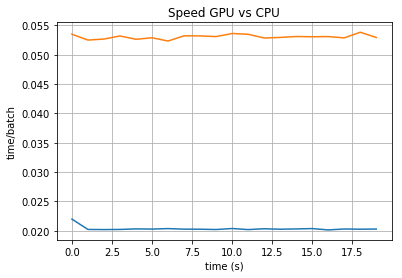

In [52]:
## Write your code here
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

t = range(num_epochs)

fig, ax = plt.subplots()
ax.plot(t, avg_batch_running_duration_GPU, avg_batch_running_duration_CPU)

ax.set(xlabel='time (s)', ylabel='time/batch',
       title='Speed GPU vs CPU')
ax.grid()

plt.show()


<h2>Do you want to use GPU in production?</h2>

<p>Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The <a href="https://cocl.us/ML0122EN_IBMCLOUD_PowerAI">PowerAI platform on IBM Cloud</a> supports popular machine learning libraries and dependencies including TensorFlow, Caffe, PyTorch, and Theano.</p>

<h3>Thanks for completing this lesson!</h3>



<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>,   <a href="https://www.linkedin.com/in/yi-leng-yao-84451275/">Yi leng Yao</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>
</article>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>